In [1]:
import tifffile
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import matplotlib
from matplotlib import rc
rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 18})

In [3]:
with tifffile.TiffFile("../dataset/raw_data/volumedata.tif") as tif:
    print(len(tif.pages))
    print(tif.pages[0].sizes)
    data = tif.asarray()

1065
{'height': 1536, 'width': 2048}


In [4]:
data.shape

(1065, 1536, 2048)

In [5]:
dataXZ = data[150:750, 510, 510:1110].reshape((600,600))
dataYZ = data[150:750, 200:800, 595].reshape((600,600))
dataXY = data[200, 200:800, 510:1110].reshape((600,600))
train_data = np.hstack([dataXY, dataXY, dataYZ])

In [6]:
with tifffile.TiffFile("/home/shov/projects/connectomics_segmentation/dataset/labeled_data/train/train_XZ/tr_seg_XZ.tif") as tif2:
    print(len(tif2.pages))
    print(tif2.pages[0].sizes)
    segXZ = tif2.asarray()
with tifffile.TiffFile("/home/shov/projects/connectomics_segmentation/dataset/labeled_data/train/train_XY/tr_seg_XY.tif") as tif2:
    print(len(tif2.pages))
    print(tif2.pages[0].sizes)
    segXY = tif2.asarray()
with tifffile.TiffFile("/home/shov/projects/connectomics_segmentation/dataset/labeled_data/train/train_YZ/tr_seg_YZ.tif") as tif2:
    print(len(tif2.pages))
    print(tif2.pages[0].sizes)
    segYZ = tif2.asarray()

1
{'height': 600, 'width': 600}
1
{'height': 600, 'width': 600}
1
{'height': 600, 'width': 600}


In [7]:
seg = np.hstack([segXZ, segXY, segYZ])
seg.shape

(600, 1800)

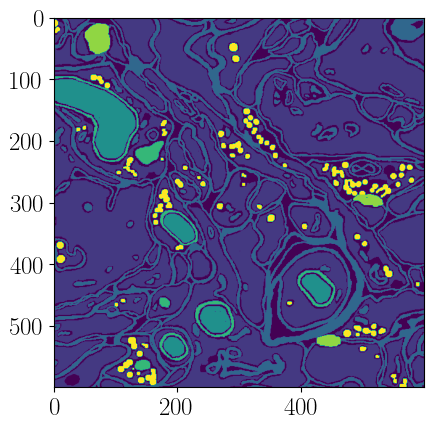

In [8]:
plt.imshow(segXZ)

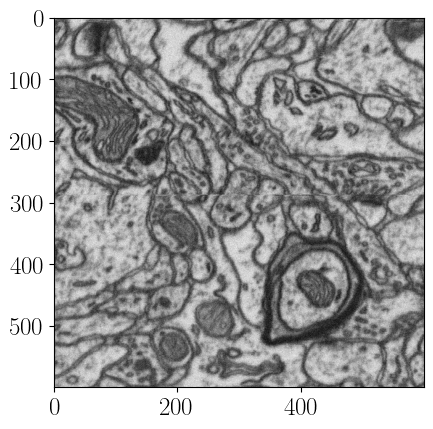

In [9]:
plt.imshow(dataXZ, cmap="gray")

In [10]:
classes = np.unique(seg)
classes

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [11]:
class_idxs = []
for cls in classes:
    class_idxs.append(np.argwhere(seg == cls))
    print(class_idxs[-1].shape)
    print("Percent: ", class_idxs[-1].shape[0] / (600 * 600 * 3) * 100)

(278643, 2)
Percent:  25.80027777777778
(497603, 2)
Percent:  46.07435185185185
(209857, 2)
Percent:  19.4312037037037
(32190, 2)
Percent:  2.980555555555555
(11881, 2)
Percent:  1.1000925925925926
(8204, 2)
Percent:  0.7596296296296297
(41622, 2)
Percent:  3.8538888888888887


In [12]:
print("Percent of non labeled: ", 278643 / (600 * 600 * 3) * 100)

Percent of non labeled:  25.80027777777778


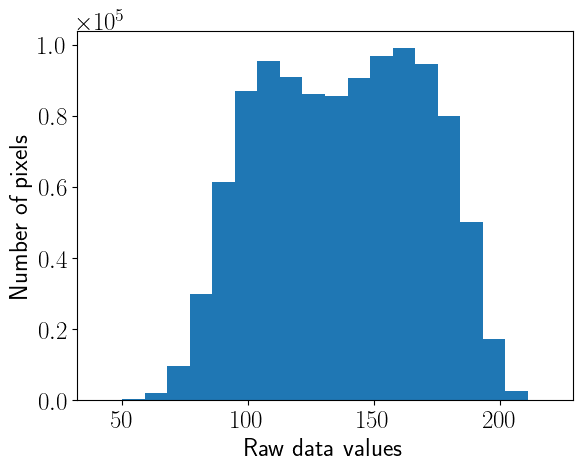

In [13]:
ax = plt.hist(train_data.flatten(), bins=20)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.xlabel("Raw data values")
plt.ylabel("Number of pixels")
# plt.savefig("../report/assets/raw_data_dist.pdf", bbox_inches = "tight")

1 154.6759284007532
2 114.82440900232062
3 123.08937558247904
4 114.4310243245518
5 112.12798634812286
6 113.33751381480947
0 131.833141331381


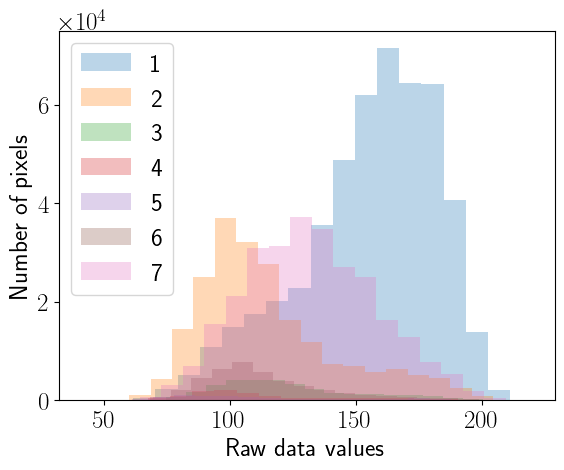

In [14]:
cls2vals = {}
for cls in np.roll(classes, -1):
    values = np.where(seg == cls, train_data, -1).flatten()
    values = values[values >= 0]
    print(cls, values.mean())
    cls2vals[cls] = values
    label = cls if cls else 7
    ax=plt.hist(values.flatten(), bins=20, label=label, alpha=0.3)
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.xlabel("Raw data values")
plt.ylabel("Number of pixels")
# plt.savefig("../report/assets/raw_data_dist_per_label.pdf", bbox_inches = "tight")

## Normality tests

In [15]:
from scipy.stats import f_oneway, ttest_ind, normaltest
from itertools import combinations

In [16]:
normaltest(train_data.flatten())

NormaltestResult(statistic=277246.85911899776, pvalue=0.0)

In [17]:
for cls in range(7):
    print(cls, normaltest(cls2vals[cls]))

0 NormaltestResult(statistic=4712.737649532382, pvalue=0.0)
1 NormaltestResult(statistic=35713.89879568762, pvalue=0.0)
2 NormaltestResult(statistic=25659.572986993022, pvalue=0.0)
3 NormaltestResult(statistic=2184.18271267309, pvalue=0.0)
4 NormaltestResult(statistic=1132.0566192874867, pvalue=1.5032406826663804e-246)
5 NormaltestResult(statistic=835.9027500370839, pvalue=3.0621335340948176e-182)
6 NormaltestResult(statistic=5676.786925311814, pvalue=0.0)


# Test that class means are different

In [18]:
f_oneway(*list(cls2vals.values()))

F_onewayResult(statistic=70230.16650952984, pvalue=0.0)

In [19]:
for i, j in combinations(range(7), 2):
    print(i, j, ttest_ind(cls2vals[i], cls2vals[j], equal_var=False))

0 1 TtestResult(statistic=-368.2104594547814, pvalue=0.0, df=605339.3592171627)
0 2 TtestResult(statistic=218.60634592227998, pvalue=0.0, df=431365.9369259815)
0 3 TtestResult(statistic=54.794367621779855, pvalue=0.0, df=39062.05160213607)
0 4 TtestResult(statistic=60.48176142351331, pvalue=0.0, df=12587.748459993925)
0 5 TtestResult(statistic=50.395728745414694, pvalue=0.0, df=8462.448680998314)
0 6 TtestResult(statistic=141.88687943906686, pvalue=0.0, df=55930.57484879486)
1 2 TtestResult(statistic=553.8481727282498, pvalue=0.0, df=386441.2717883403)
1 3 TtestResult(statistic=201.43923782190961, pvalue=0.0, df=36454.02053871727)
1 4 TtestResult(statistic=140.61901368334648, pvalue=0.0, df=12323.023448556381)
1 5 TtestResult(statistic=109.12911581131218, pvalue=0.0, df=8365.765538259453)
1 6 TtestResult(statistic=325.63004411018284, pvalue=0.0, df=50462.98889789739)
2 3 TtestResult(statistic=-50.49324585832255, pvalue=0.0, df=43128.35689231558)
2 4 TtestResult(statistic=1.356382545581